legi: 22-942-684

# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [2]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

from sklearn.metrics.pairwise import cosine_similarity
import warnings


# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [3]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [4]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [5]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        
        self.PMAT = None
        self.S_c = None # centered Similarity matrix
        self.S_shifted = None # shifted Similarity matrix
        self.D_shifted = None # shifted Dissimilarity matrix
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        
        n = PMAT.shape[0] 
        
        # computes symmetrized D
        D = 1-cosine_similarity(PMAT.copy())
        D[D == np.inf] = 12
        
        sym_D=0.5*(D.T+D) #we calculate the symmetrized Dissimilarity matrix
        centr_matrix=np.eye(n)-1/n*np.ones((n,n))
        
        D_centr=np.matmul(centr_matrix, sym_D.dot(centr_matrix)) #calculates centred Dissimilarity
        self.S_c=-0.5*D_centr #calculates centred Similarity
        
        eig=np.linalg.eigvalsh(self.S_c) #computes eigenvalues of S_c
        lambda_min=eig[0] #eigvalsh returns eigenvalues in ascending order, hence this line takes minimum eigenvalue of S_c
        
        self.D_shifted=sym_D-2*lambda_min*(np.ones((n,n))-np.eye(n))
        
        self.S_shifted=-0.5*np.matmul(centr_matrix, self.D_shifted.dot(centr_matrix))
    
        
        
    def get_embedded_vectors(self, p=None):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        n = self.PMAT.shape[0]
        
        eigenvalues, eigenvectors=np.linalg.eigh(self.S_shifted)
        
        sorted_eigenvalues=eigenvalues[::-1] #sort eigenvalues in descending order
        sorted_eigenvectors=eigenvectors[:, ::-1]
        
        #it may happen for numerical approximations that the last eigenvalue
        #which is supposed to be 0 is actually negative. We then set it to 0 by hand
        #as otherwise it may return a Nan value when we calculate the square root for the embedding
        
        for i in range(len(sorted_eigenvalues)):
            if sorted_eigenvalues[i]<0:
                sorted_eigenvalues[i]=0 
        
        if p is not None:
            lambda_p=np.diag(sorted_eigenvalues[0:p]) #construct diagonal matrices of p biggest eigenvalues
            eigenvectors_p=sorted_eigenvectors[:, 0:p] #takes the eigenvectors corresponding to p biggest eigenvalues
        
        else:
            lambda_p=np.diag(sorted_eigenvalues)
            eigenvectors_p=sorted_eigenvectors.copy()

        X_p=eigenvectors_p.dot(np.sqrt(lambda_p))
        return X_p


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: (Put your answer here)


Constant shift embedding is an algorithm that is useful to transform Dissimilarity matrices/data into an embedding. This is particularly useful since most algorithms for clustering rely on the fact that data come from an Euclidean space (or a more general metric space) and hence they assume it is reasonable to calculate distances directly from row data. In many applications, however, this assumption is not satisfied and hence it is necessary to preprocess the data (and in particular, in this case, the dissimilarity between the data) and embed it into a metric space. CSE, in particular, returns for each dissimilarity a point in a metric space which represents the embedded dissimilarity (which can be represented as a distance in that particular space).

CSE is composed of the following steps:

Symmetrization: \
$D_{sym}=\frac{1}{2}(D+D^T)$

Centralization: \
$D_c=QD_{sym}Q$, where $Q=I_n-\frac{1}{n}e_ne_n^T$\
$S_c=-\frac{1}{2} D_c$


Minimal Shift: \
$D_{shifted}=D_{sym}-2\lambda_n(S_c)(e_ne_n^T-I_n)$
    
Finally, to recover the embedding, CSE executes these last steps:

Computes the shifted similarity matrix: \
$S_{shifted, c}=QD_{shifted}Q$

Computes eigenvalue decomposition of $S_{shifted, c}$: \
$S_{shifted, c}=V \Lambda V^T$

Calculates embedding (by using p largest eigenvalues and corresponding eigenvectors): \
$X_p=V_p \Lambda_p^{1/2}$



<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [6]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [7]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

In [8]:
## Compute eigen-spectrum

In [9]:
S_c_eigenvalues=np.linalg.eigvalsh(CSE.S_c) #we calculate the eigenvalues of the centred similarity matrix

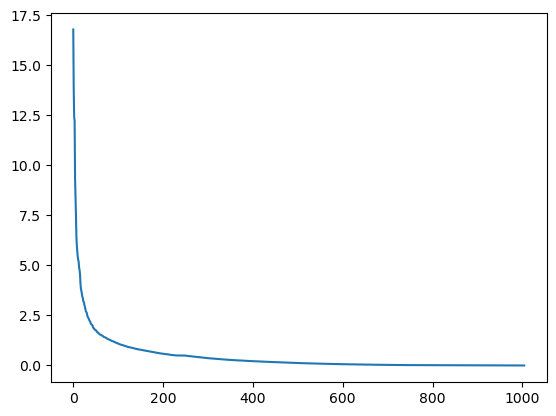

In [10]:
#we first plot the eigenvalues to decide which cut-off to take 

plt.plot(S_c_eigenvalues[::-1]) 

In [11]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 40 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  40


To estimate the optimal cutoff, we simply looked at the plot above and took the value where
the eigenvalue curve had an "elbow", i.e. eigenvalues start to decrease slower after this point 
(this method is indeed often called "elbow" in PCA).The rationale behind this is saying that
since the eigenvalues start to decrease much slower, they don't have as much contribution in the corresponding
eigendirections as the bigger ones have with respect to them. Hence, we are "allowed" to discard them since
we can assume that they essentially do not contribute in shaping the manifold the data lives in

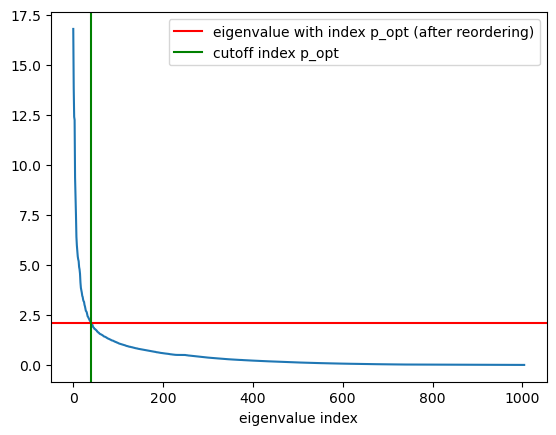

In [12]:
## Plot spectrum and indicate the cut-off value on the spectrum

#now we plot the eigenvalues again with the p_opt threshold, as in figure 4a) of reference 1)

warnings.filterwarnings("ignore")

plt.plot(S_c_eigenvalues[::-1])
plt.axhline(y=S_c_eigenvalues[-p_opt], linestyle='-', c='red', label='eigenvalue with index p_opt (after reordering)')
plt.axvline(x=p_opt, linestyle='-', c='green', label='cutoff index p_opt')
plt.legend() 
plt.xlabel('eigenvalue index')

plt.show()

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [13]:
#aligning clustering labels with ground truth labels (taken from previous assignments)

def match(y_pred, y_truth):
    
    labels_map = np.argmax(skl.metrics.cluster.contingency_matrix(y_pred, y_truth), axis=1)
    y_new = []
    for y in y_pred:
        y_new.append(labels_map[y])
        
    return np.array(y_new)

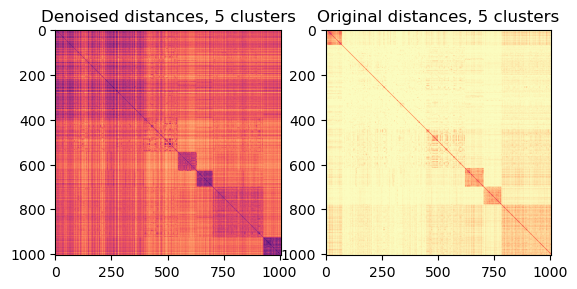

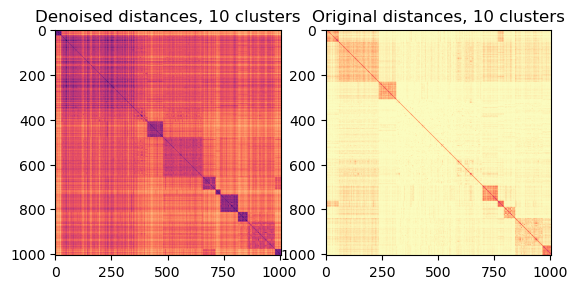

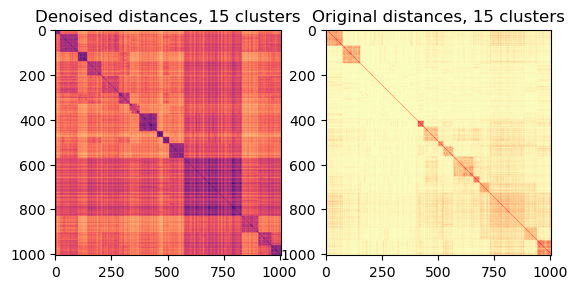

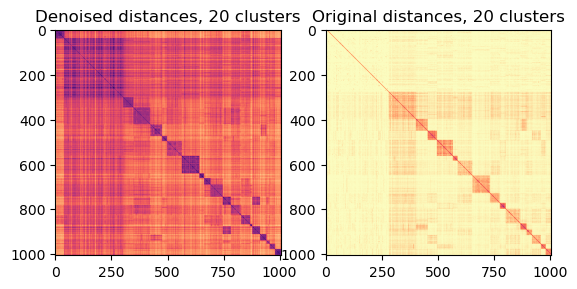

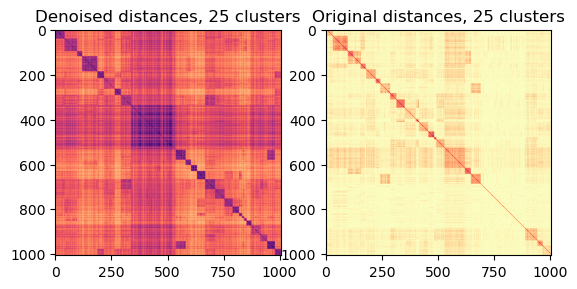

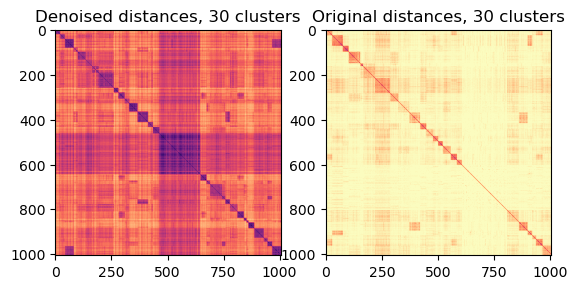

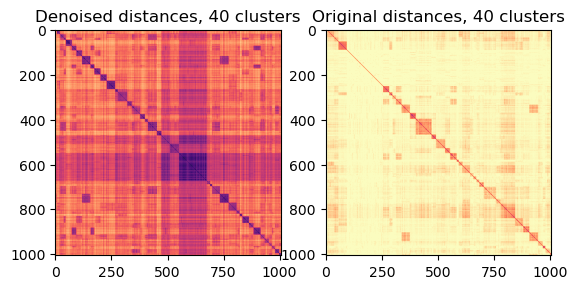

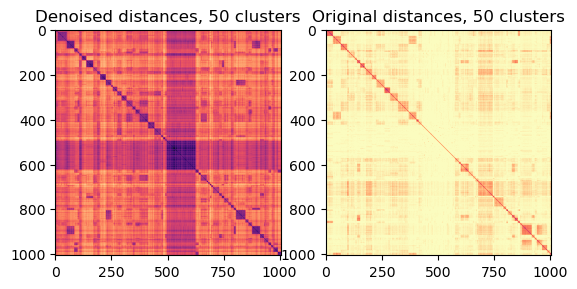

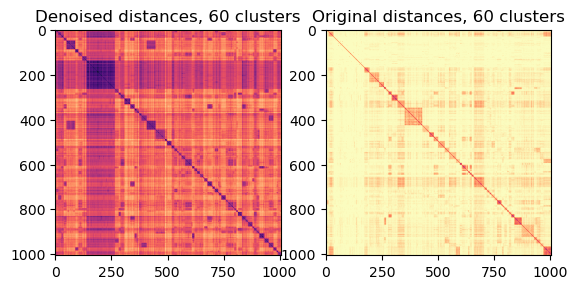

In [14]:
## Distance matrices

import scipy.spatial as spt 

denoised_embedded_points=CSE.get_embedded_vectors(p=p_opt)
original_embedded_points=CSE.get_embedded_vectors()

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    fix, axs= plt.subplots(1,2)
    denoised_distance = spt.distance.squareform(spt.distance.pdist(denoised_embedded_points)) #calculates the distance matrix
    cluster_predictions = skl.cluster.KMeans(k).fit_predict(denoised_embedded_points) #calculates cluster predictions
    idx = np.argsort(cluster_predictions) #sorts the points with respect to cluster assignment
    axs[0].imshow(denoised_distance[idx][:,idx], cmap='magma')
    axs[0].set_title('Denoised distances, '+str(k) +' clusters')
    
    original_distance = spt.distance.squareform(spt.distance.pdist(original_embedded_points))
    original_cluster_predictions= skl.cluster.KMeans(k).fit_predict(original_embedded_points)
    
    #we need to match original cluster predictions labels with the denoised cluster predictions labels to compare the plots

    matched_original_cluster_predictions=match(cluster_predictions, original_cluster_predictions)
    matched_idx = np.argsort(matched_original_cluster_predictions)
    axs[1].imshow(original_distance[matched_idx][:,matched_idx], cmap='magma')
    axs[1].set_title('Original distances, '+str(k) +' clusters')
    

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [15]:
## Get embeddings, run K-MEANS and generate plots

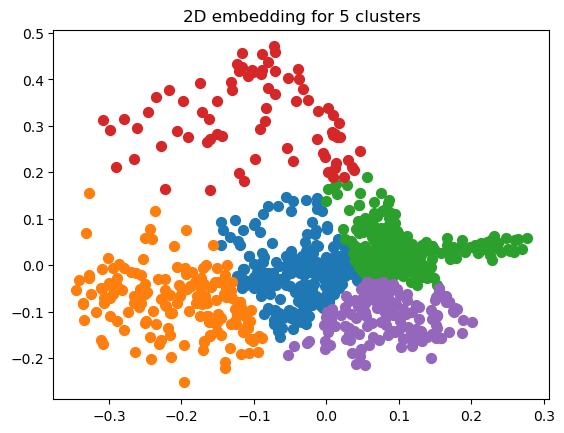

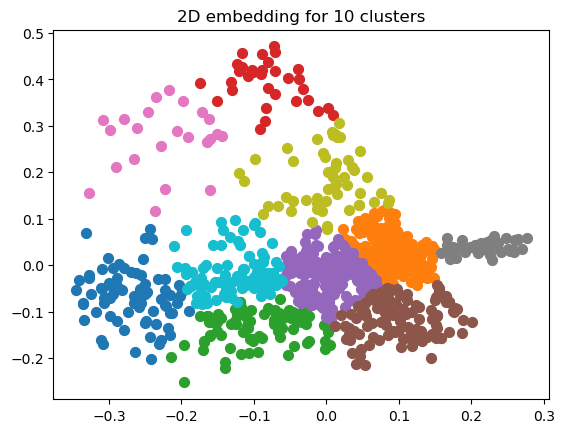

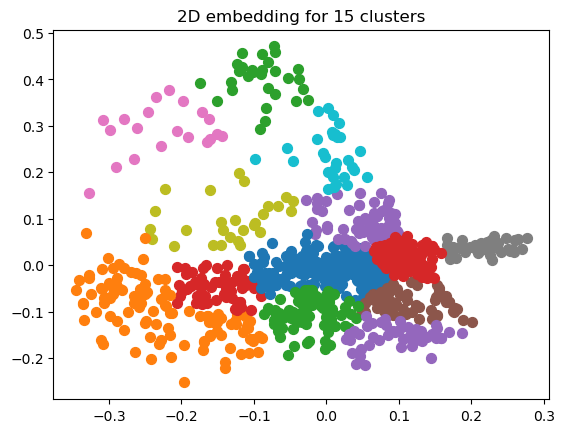

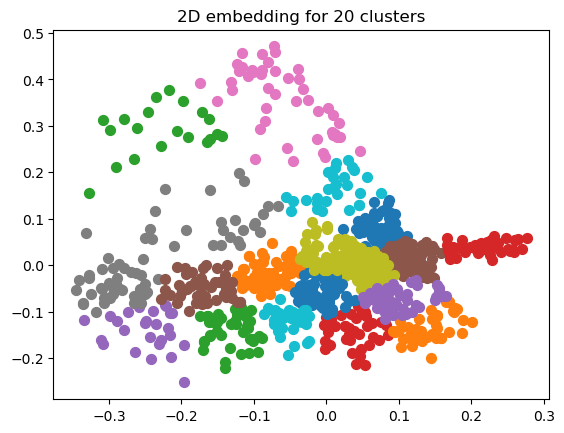

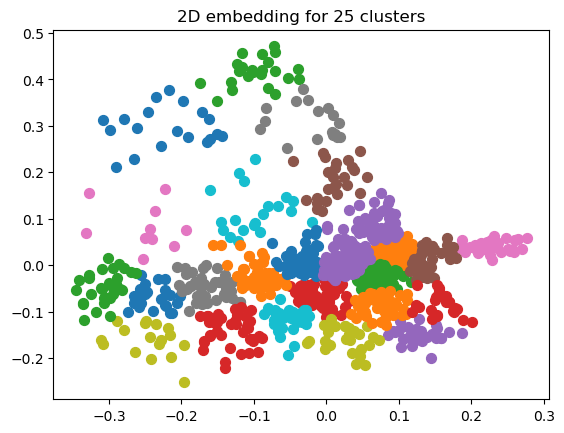

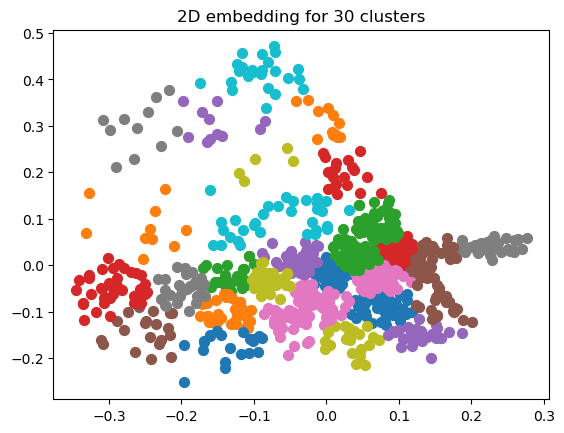

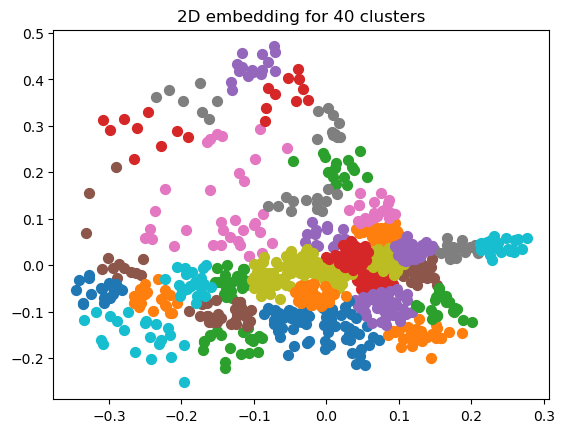

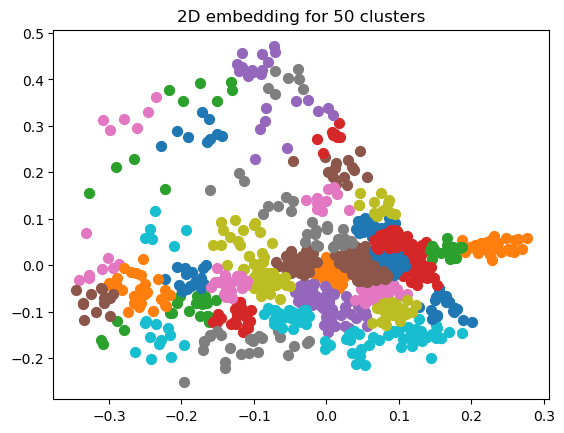

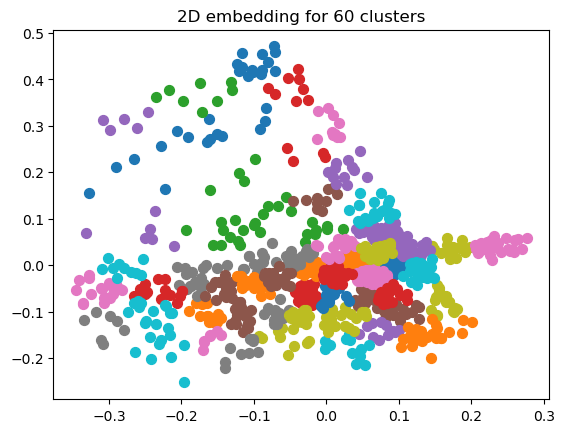

In [16]:
## p = 2

warnings.filterwarnings("ignore")

embedded_points_2d=CSE.get_embedded_vectors(p=2)

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    cluster_predictions=skl.cluster.KMeans(k).fit_predict(embedded_points_2d)
    
    plt.figure()
    
    for i in range(k):
        indices=np.where(cluster_predictions==i)
        plt.scatter(embedded_points_2d[indices, 0], embedded_points_2d[indices, 1], s=50)
    
    plt.title("2D embedding for " + str(k) + " clusters")

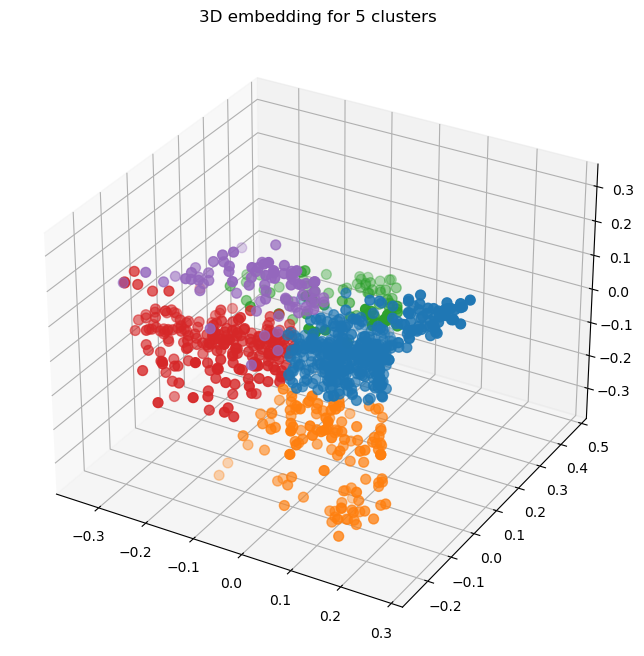

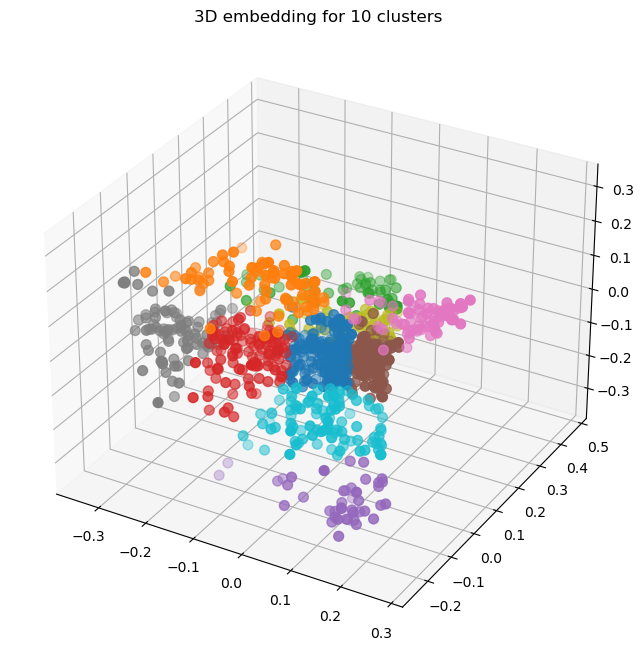

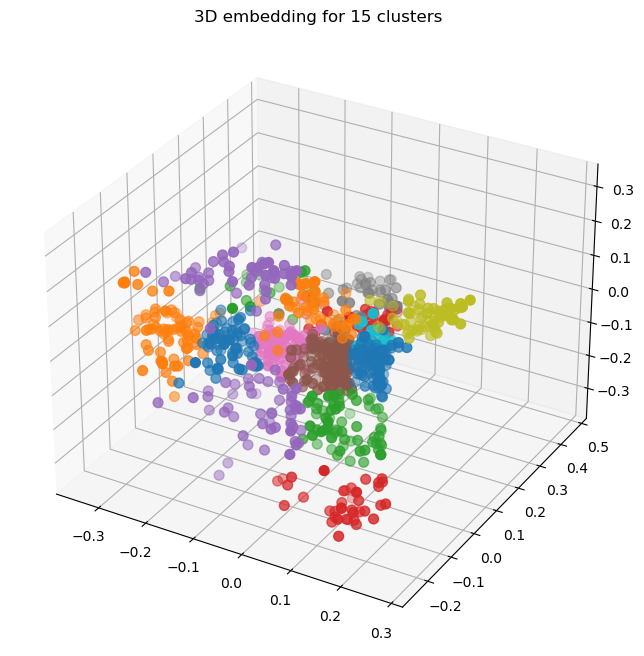

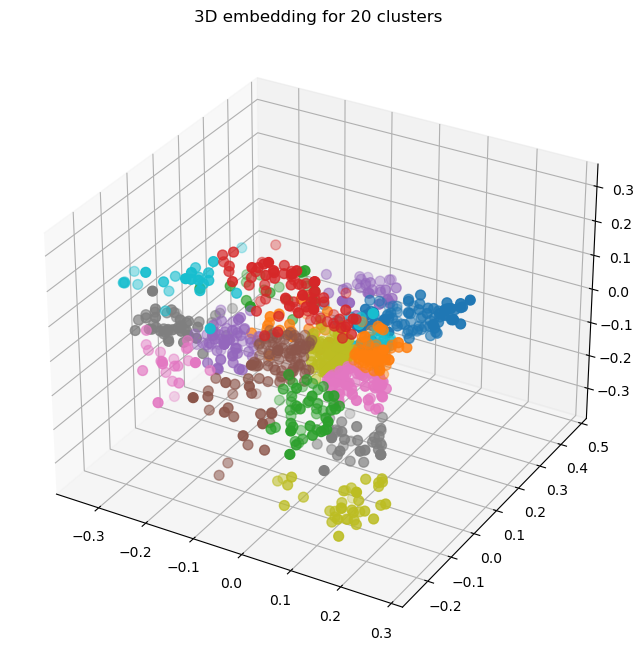

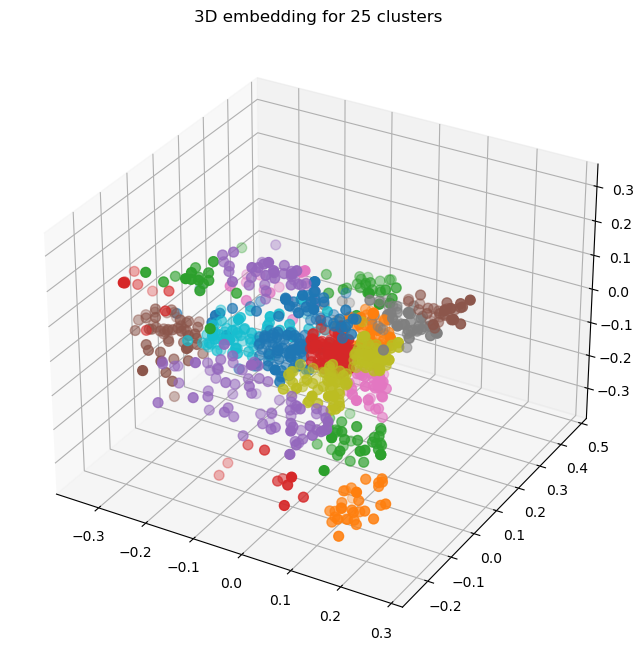

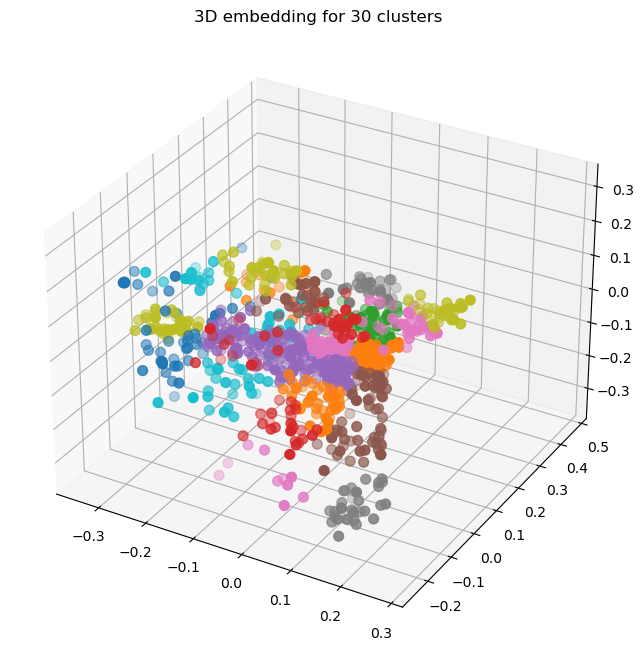

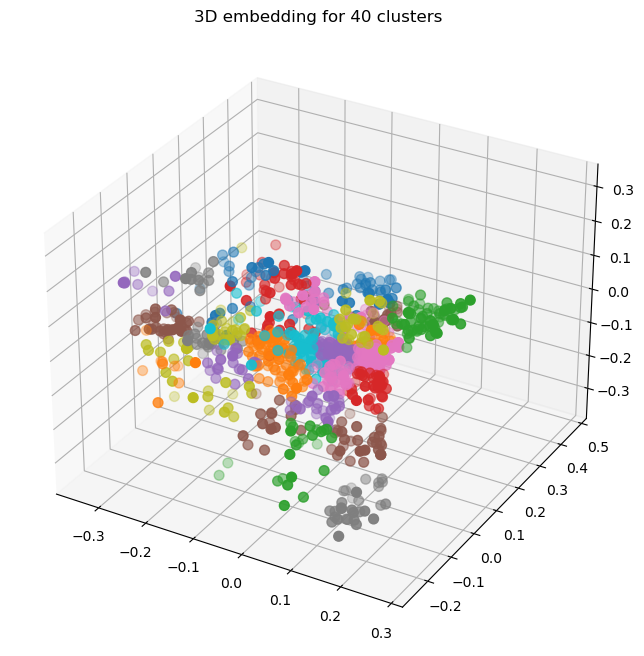

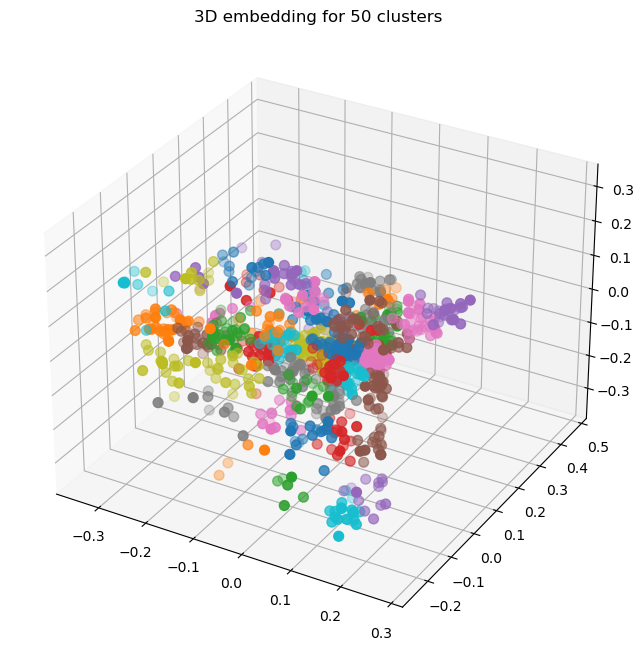

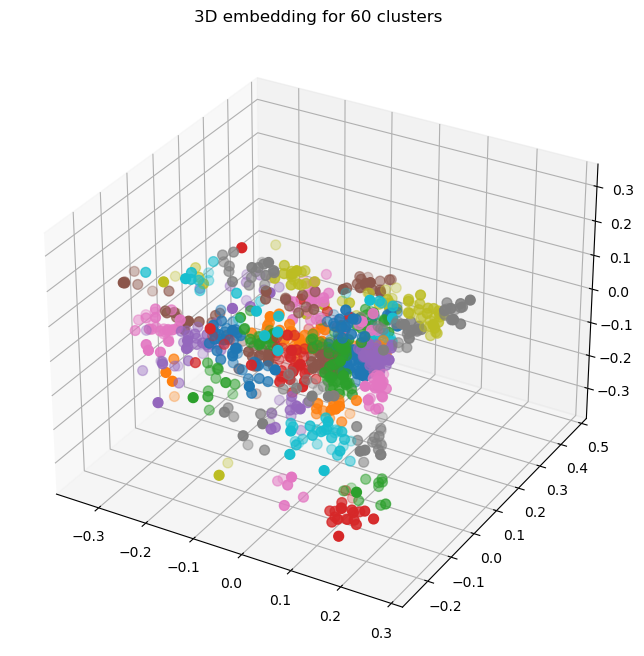

In [17]:
## p = 3

embedded_points_3d=CSE.get_embedded_vectors(p=3)

warnings.filterwarnings("ignore")

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    cluster_predictions=skl.cluster.KMeans(k).fit_predict(embedded_points_3d)
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection="3d")
    
    for i in range(k):
        indices=np.where(cluster_predictions==i)
        ax.scatter(embedded_points_3d[indices, 0], embedded_points_3d[indices, 1], embedded_points_3d[indices, 2], s=50)
    
    ax.set_title("3D embedding for " + str(k) + " clusters")

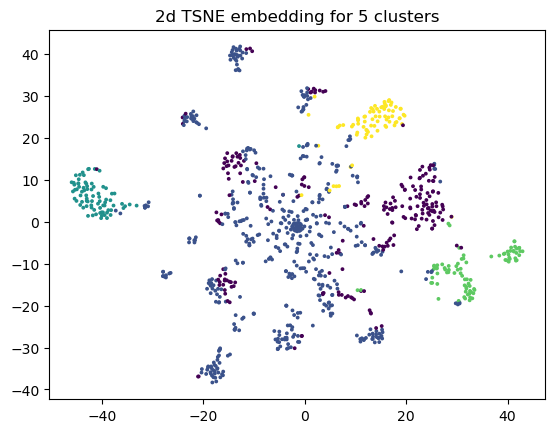

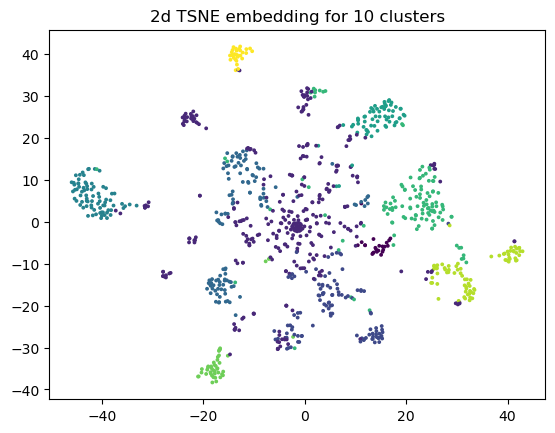

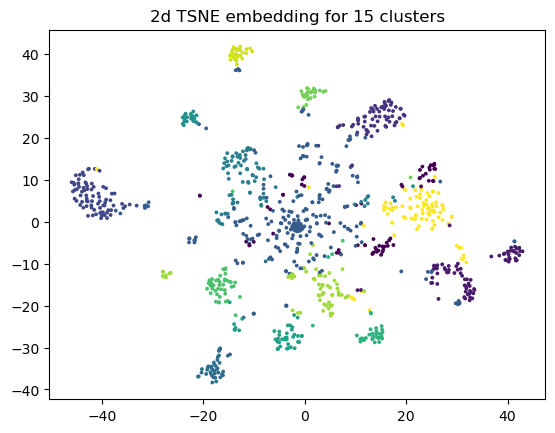

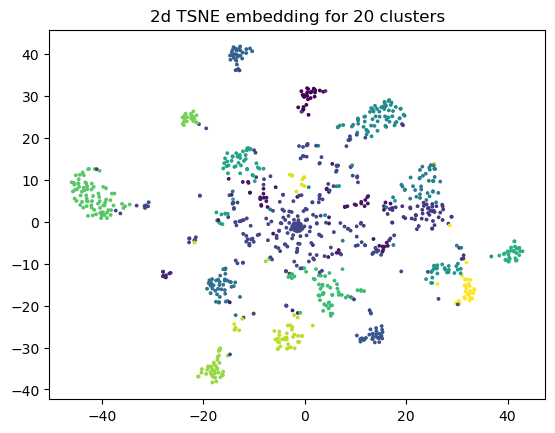

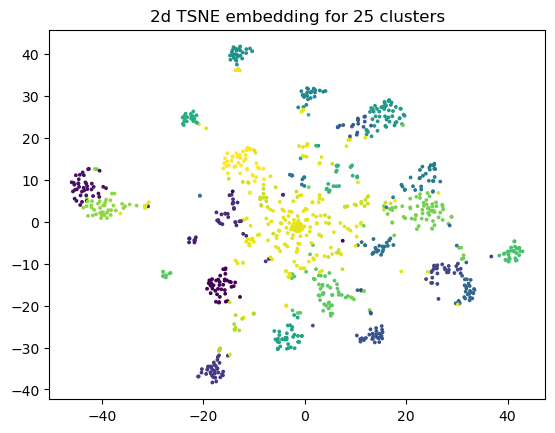

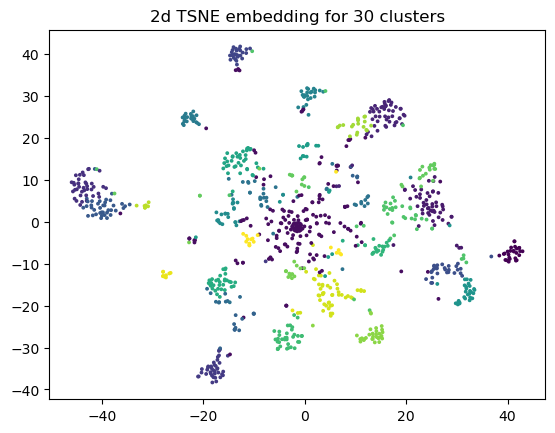

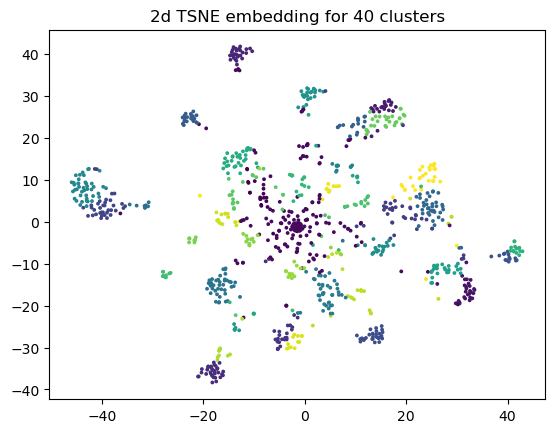

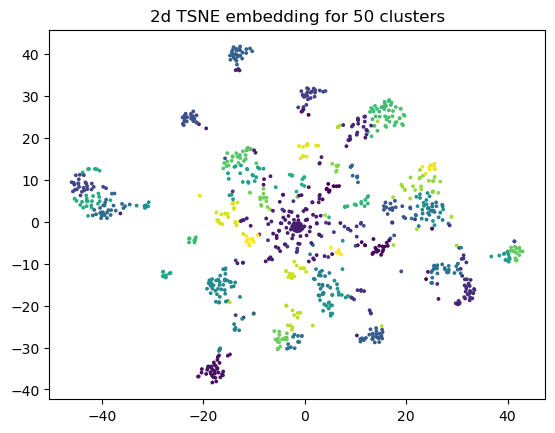

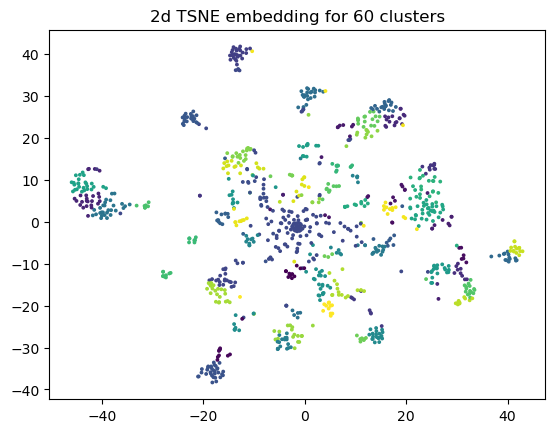

In [18]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else

from sklearn.manifold import TSNE

embedded_points_p_opt=CSE.get_embedded_vectors(p=p_opt)

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    cluster_predictions=skl.cluster.KMeans(k).fit_predict(embedded_points_p_opt)
    
    tsne = TSNE(n_components = 2, random_state=42)
    embedding= tsne.fit_transform(embedded_points_p_opt)
    plt.scatter(embedding[:,0], embedding[:,1], c=cluster_predictions, s=3, cmap='viridis')
    plt.title("2d TSNE embedding for " + str(k) + " clusters")
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [19]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

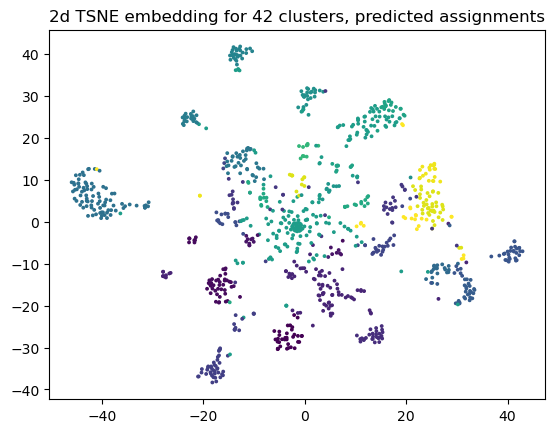

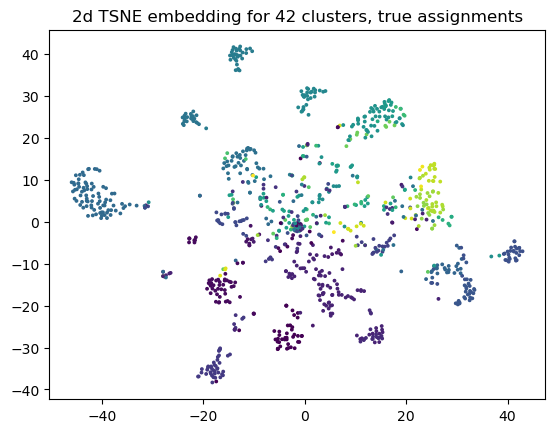

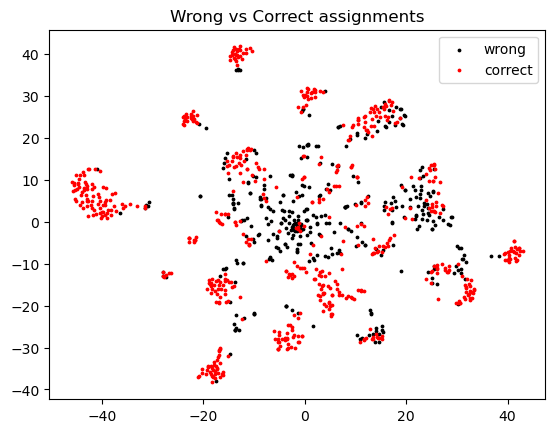

In [20]:
## Here you can provide plots and calculations

embedded_points_p_opt = CSE.get_embedded_vectors(p_opt)
predicted_assignments = skl.cluster.KMeans(42).fit_predict(embedded_points_p_opt)
matched_assignments= match(predicted_assignments, AFFILIATIONS)

embedding= TSNE(n_components = 2, random_state=42).fit_transform(embedded_points_p_opt)
plt.scatter(embedding[:,0], embedding[:,1], c=matched_assignments, s=3, cmap='viridis')
plt.title("2d TSNE embedding for 42 clusters, predicted assignments")
plt.show()

plt.scatter(embedding[:,0], embedding[:,1], c=AFFILIATIONS, s=3, cmap='viridis')
plt.title("2d TSNE embedding for 42 clusters, true assignments")
plt.show()

correct_assignments=np.zeros(len(matched_assignments))
correct_assignments[np.where(matched_assignments==AFFILIATIONS)]=1

plt.scatter(embedding[np.where(correct_assignments==0),0], embedding[np.where(correct_assignments==0),1],s=3, c="black", label='wrong', cmap='viridis')
plt.scatter(embedding[np.where(correct_assignments==1),0], embedding[np.where(correct_assignments==1),1],s=3,c="red", label='correct', cmap='viridis')
plt.title("Wrong vs Correct assignments")
plt.legend()

plt.show()

In [21]:
accuracy = skl.metrics.accuracy_score(AFFILIATIONS, matched_assignments)
print('Accuracy: ', accuracy)

MIB = skl.metrics.normalized_mutual_info_score(AFFILIATIONS, matched_assignments)
print('Mutual Information Based Score: ', MIB)

ARI = skl.metrics.adjusted_rand_score(AFFILIATIONS, matched_assignments)
print('Adjusted Rand Index: ', ARI)


Accuracy:  0.6318407960199005
Mutual Information Based Score:  0.6392385094843781
Adjusted Rand Index:  0.4089350119108126


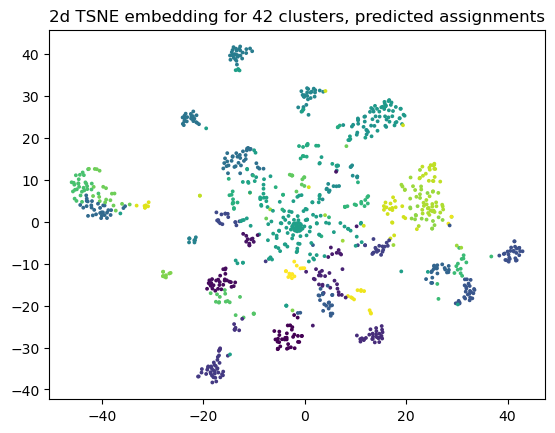

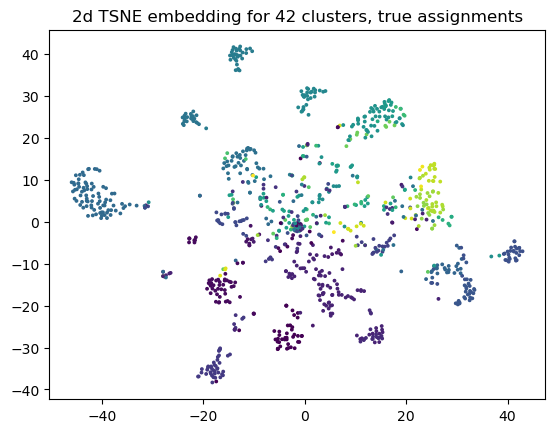

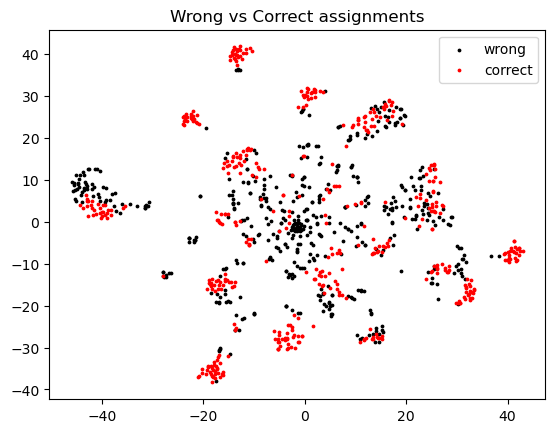

In [27]:
#we repeat the experiments above but using the Hungarian algorithm for matching instead of the more greedy algorithm that
#we have used above

from scipy.optimize import linear_sum_assignment


embedded_points_p_opt = CSE.get_embedded_vectors(p_opt)
predicted_assignments = skl.cluster.KMeans(42).fit_predict(embedded_points_p_opt)

cost_matrix=np.zeros((len(np.unique(AFFILIATIONS)), len(np.unique(AFFILIATIONS)))).astype(int)

for i in range(len(AFFILIATIONS)): 
    #cost_matrix[int(AFFILIATIONS[i])][int(predicted_assignments[i])]+=1 
    cost_matrix[int(predicted_assignments[i])][int(AFFILIATIONS[i])]+=1 
        
HC_row_ind, HC_col_ind=linear_sum_assignment(1000-cost_matrix)

H_matched_assignments=np.zeros(len(AFFILIATIONS))
for i in range(len(H_matched_assignments)):
    H_matched_assignments[i]= HC_col_ind[predicted_assignments[i]]

embedding= TSNE(n_components = 2, random_state=42).fit_transform(embedded_points_p_opt)
plt.scatter(embedding[:,0], embedding[:,1], c=H_matched_assignments, s=3, cmap='viridis')
plt.title("2d TSNE embedding for 42 clusters, predicted assignments")
plt.show()

plt.scatter(embedding[:,0], embedding[:,1], c=AFFILIATIONS, s=3, cmap='viridis')
plt.title("2d TSNE embedding for 42 clusters, true assignments")
plt.show()

correct_assignments=np.zeros(len(matched_assignments))
correct_assignments[np.where(H_matched_assignments==AFFILIATIONS)]=1

plt.scatter(embedding[np.where(correct_assignments==0),0], embedding[np.where(correct_assignments==0),1],s=3, c="black", label='wrong', cmap='viridis')
plt.scatter(embedding[np.where(correct_assignments==1),0], embedding[np.where(correct_assignments==1),1],s=3,c="red", label='correct', cmap='viridis')
plt.title("Wrong vs Correct assignments")
plt.legend()

plt.show()

In [28]:
accuracy = skl.metrics.accuracy_score(AFFILIATIONS, H_matched_assignments)
print('Accuracy: ', accuracy)

MIB = skl.metrics.normalized_mutual_info_score(AFFILIATIONS, H_matched_assignments)
print('Mutual Information Based Score: ', MIB)

ARI = skl.metrics.adjusted_rand_score(AFFILIATIONS, H_matched_assignments)
print('Adjusted Rand Index: ', ARI)


Accuracy:  0.47562189054726367
Mutual Information Based Score:  0.6349440230737086
Adjusted Rand Index:  0.28256894523852116


Please, write here your explanations, observation and thoughts about results of the experiments above.

In order to verify overlapping between the true clusters and the generated clusters, we first calculate the embedded points and predict assignments using Kmeans.  After this, we first match the predicted assignments with the true assignments. Then, we perform a 2-d TSNE embedding on the embedded points. To compare the predicted and true assignments, we color the 2d-TSNE points according to their assignment (in the first plot, according to the predicted assignment and in the second plot according to the ground truth). Finally, in the third plot we also use the 2d-TSNE embedding points and we color them accordingly if they were correctly assigned to the true cluster or not. As we see, a good fraction of points (considering that the number of cluster is 42, which is fairly high) was correctly assigned to their true cluster, hence suggesting the presence of an overlapping. Finally, to get more concrete quantitative results, we calculate the accuracy, the Mutual Information Based Score and the Adjusted Rand Index for our predictions. As we said above, the accuracy is not very high but when we also consider the fact that the number of cluster is high, the algorithm performs fairly well. The Mutual Information score, which measures the agreement betweem two labeling strategies (namely the ground truth and the predictions), is also fairly high. Although usually this score is used when we do not have access to the ground truth, we can still use this by thinking of the ground truth as a labeling process as well. The Adjusted Rand Index, altough not high, is well above 0 (which indicates random guess), again suggesting the presence of an overlapping between true and predicted clusters. As a last remark, the choice for the cosine similarity as a metric was guided by the fact that Euclidean Distance performed really poorly for this problem. \
\
We note that when we perform matching with the Hungarian algorithms, this gets a poorer performance than the other option we used. This may be due to the fact that Hungarian algorithm is forced to ensure a one to one mapping between the labels, whereas the other matching algorithm, which we also used in assignment 2, does not guarantee a one to one correspondance. In particular, it can happen (like in this case) that some clusters are merged, in the sense that multiple clusters predictions labels are assigned to the same ground truth label after matching. Hence, if we want to guarantee a one to one correspondance between the labels, Hungarian algorithm is to be preferred at the cost of a lower accuracy, whereas if we only seek for accuracy, the other matching algorithm remains an option. It is to be noticed that, although the Hungarian algorithm has a lower accuracy, it can be still noticed that an overlapping between predictions and ground truth is still present (as also indicated by the Mutual Information Based Score and the Adjusted Rand Index).\
\
We still report the results from both matching methods for completeness.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.